In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline



[[  1.12500000e+03   0.00000000e+00   4.80000000e+02]
 [  0.00000000e+00   1.12500000e+03   3.60000000e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ 0.  0.  0.  0.  0.]]


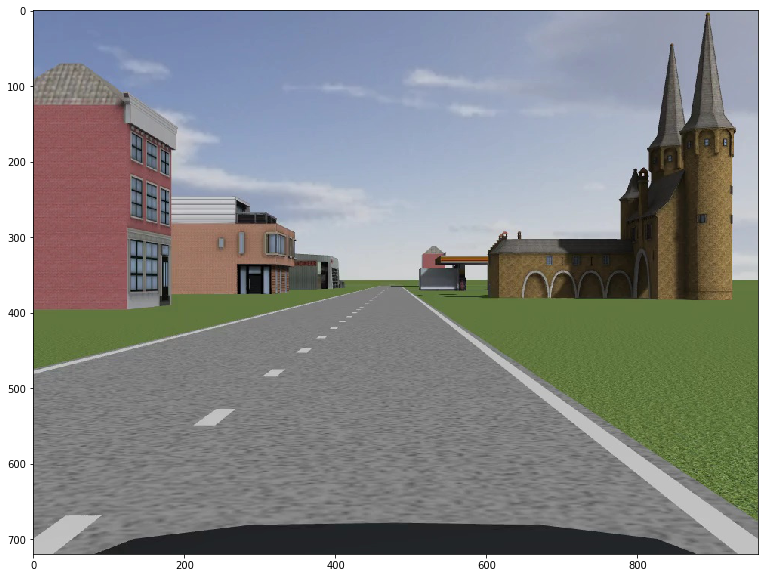

In [2]:
# Test undistortion on an image
img = mpimg.imread('./post_calib/0000.jpg')
img_size = (img.shape[1], img.shape[0])

# Ideal parameters
mtx = np.array([[  1125.0,   0.00000000e+00,   480],
       [  0.00000000e+00,   1125.0,   360],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
print(mtx)
dist = np.array([[0.0, 0, 0, 0, 0]])
print(dist)

plt.figure(figsize=(20,10))
plt.imshow(img)

720 960


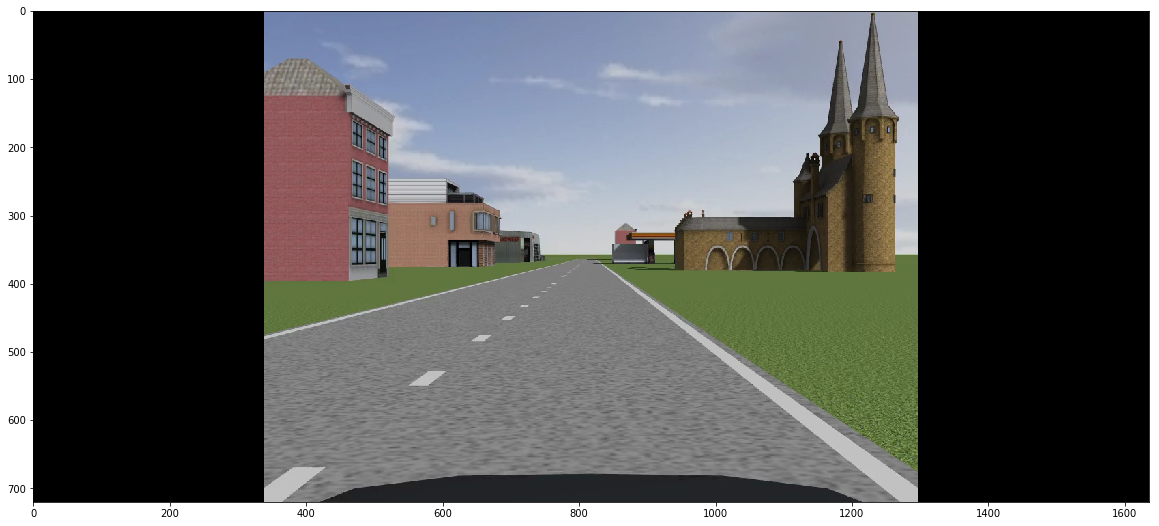

In [3]:
height = img.shape[0]
width = img.shape[1]

print(height, width)

ew = 338
v2 = 434.25
u2 = 331.25

Width = width+2*ew

IM = np.zeros((height, width+2*ew,3), np.uint8)
for i in range(width):
    IM[:, ew+i, :] = img[:,i,:]

plt.figure(figsize=(20,10))
plt.imshow(IM)

In [4]:
from detector import Detector, print_prof_data

dist_pickle = pickle.load( open( "cam_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

detector = Detector(mtx=mtx, dist=dist, M=M, Minv=Minv, sx_thresh=(20,100), s_thresh=(170,255))
# Set number of buffers
detector.LeftLine.N = 5
detector.RightLine.N = 5
# Parameters of Kalman filter. KF is not adoppted here and forget those parameters
q=[10, 10, 20]
R=[1, 1, 1]
detector.setKF_PR(q, R)
# Set margins
detector.setMargin(60)
# Set color transforms
detector.setBinaryFun(flag=5)
# Turn off Kalman filter
detector.switchKF(False)


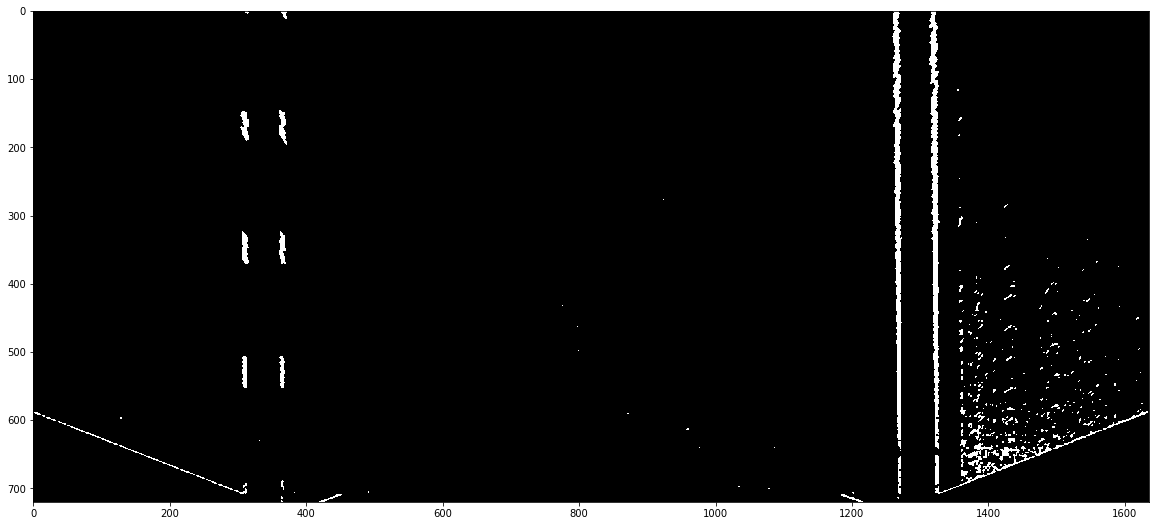

In [5]:
bin_warp = detector.detectStraight(IM)

plt.figure(figsize=(20,10))
plt.imshow(bin_warp, cmap='gray')

In [6]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    line_image = np.copy(img)*0 #creating a blank to draw lines on

    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = np.arctan((y2-y1)/(x2-x1))
            if theta >35*np.pi/180 or theta<-35*np.pi/180:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    return line_image
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = draw_lines(line_img, lines)
    return line_img


/home/changjie/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in int_scalars


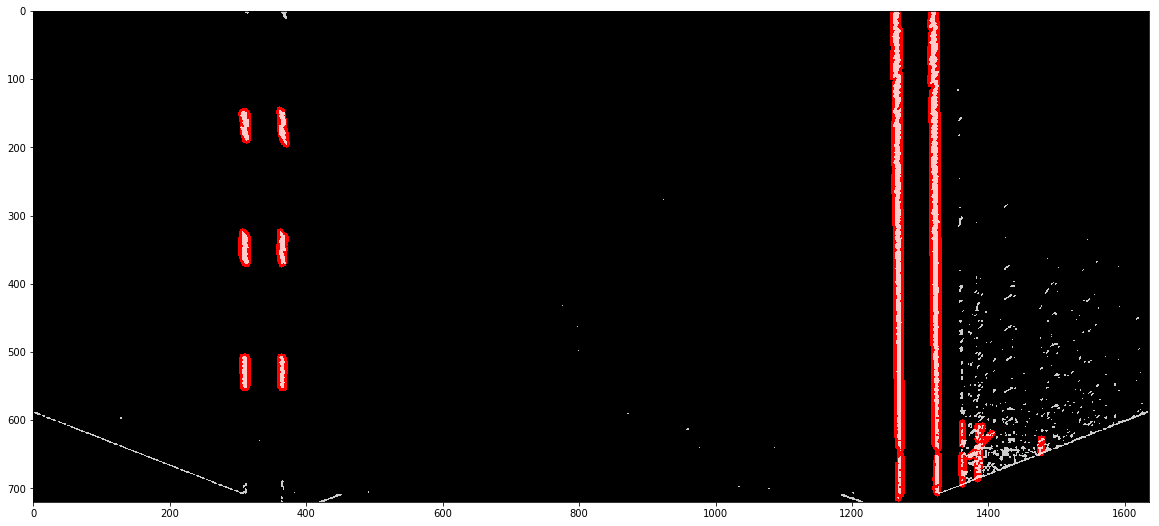

In [7]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 20 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments

bin_warp = bin_warp*255
lines = hough_lines(bin_warp, rho, theta, threshold, min_line_len, max_line_gap)

color_edges = np.dstack((bin_warp, bin_warp, bin_warp))

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, lines, 1, 0)
plt.figure(figsize=(20,10))
plt.imshow(combo)


[[ -1.00322095e+00  -2.27940928e+00   1.63889527e+03]
 [ -1.55431223e-15  -2.52428998e+00   1.09364863e+03]
 [ -2.16840434e-18  -2.78612093e-03   1.00000000e+00]]


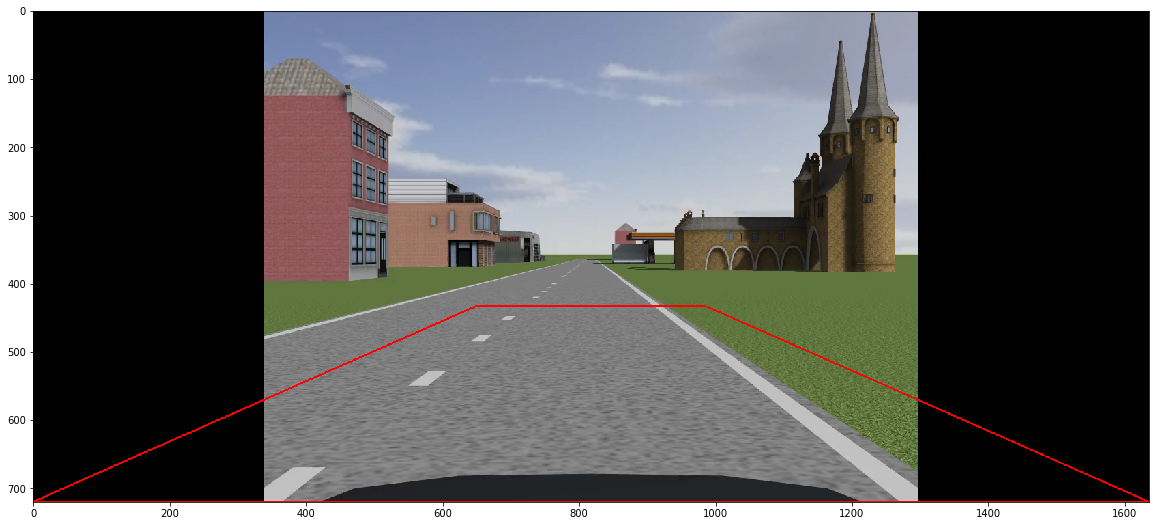

In [4]:

# Set the view of perspective
pts_list = [[0,height-1],[ew+u2-20, v2-1], [ew+width-u2+20,v2-1], [width+2*ew-1,height-1]]
pts_list_dst = [[0,height-1],[0,0],[Width-1,0],[Width-1,height-1]]
pts = np.array(pts_list, np.int32)
pts = pts.reshape((-1,1,2))
tmp = np.copy(IM)

# Draw the ROI on the image
cv2.polylines(tmp,[pts],True,(255,0,0), thickness=2)
plt.figure(figsize=(20,10))
plt.imshow(tmp)

points_src = np.float32(pts_list)
points_dst = np.float32(pts_list_dst)

M = cv2.getPerspectiveTransform(points_src, points_dst)
Minv = cv2.getPerspectiveTransform(points_dst, points_src)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump( dist_pickle, open( "cam_pickle.p", "wb" ) )

print(M)

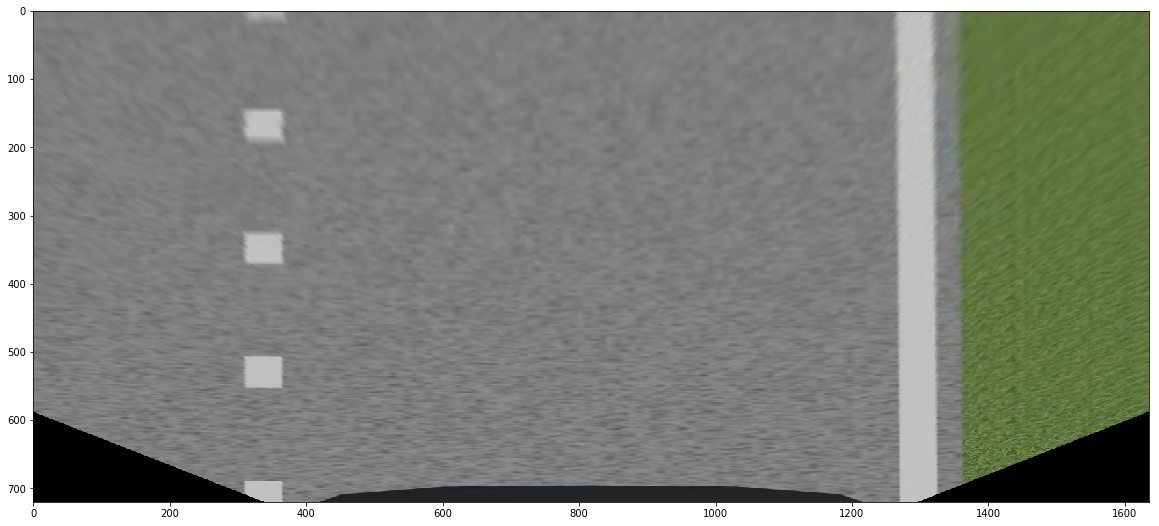

In [5]:
warped = cv2.warpPerspective(IM, M, (IM.shape[1], IM.shape[0]))

plt.figure(figsize=(20,10))
plt.imshow(warped)


In [6]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

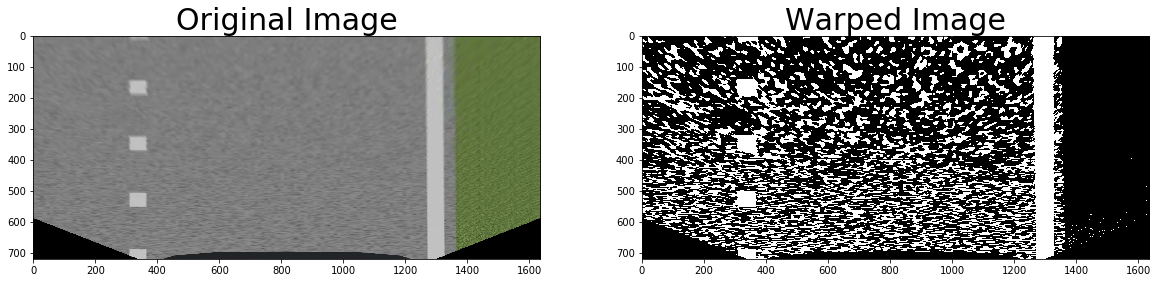

In [7]:
gray = grayscale(warped)

#th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#            cv2.THRESH_BINARY,11,2)

ret,th3 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(th3, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)


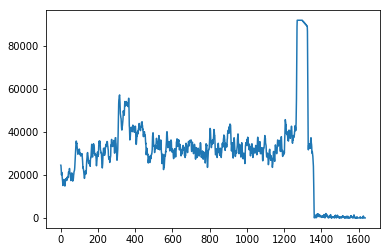

In [8]:
# Show the hist
tmp=th3
histogram = np.sum(tmp[tmp.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [9]:
def initializeLD(binary_warped):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, left_fitx, right_fitx

In [10]:
def visualize(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result 

(720, 0)

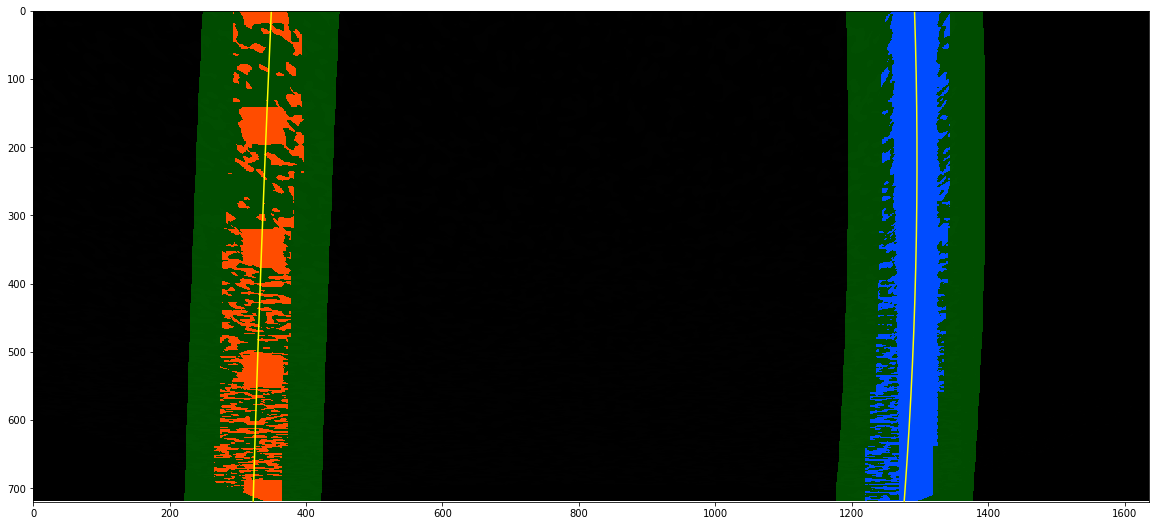

In [13]:

binary_warped = tmp
left_fit, right_fit, left_lane_inds, right_lane_inds, left_fitx, right_fitx = initializeLD(tmp)
out_img = visualize(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, ew*2+960)
plt.ylim(720, 0)

In [16]:
print((left_fitx[0]+right_fitx[0])/2)
print((ew*2+960)/2)
print((-left_fitx[0]+right_fitx[0]))

820.728040508
818.0
942.870432726


In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from detector import Detector, print_prof_data
%matplotlib inline


dist_pickle = pickle.load( open( "cam_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

detector = Detector(mtx=mtx, dist=dist, M=M, Minv=Minv, sx_thresh=(20,100), s_thresh=(170,255))
# Set number of buffers
detector.LeftLine.N = 5
detector.RightLine.N = 5
# Parameters of Kalman filter. KF is not adoppted here and forget those parameters
q=[10, 10, 20]
R=[1, 1, 1]
detector.setKF_PR(q, R)
# Set margins
detector.setMargin(60)
# Set color transforms
detector.setBinaryFun(flag=5)
# Turn off Kalman filter
detector.switchKF(False)

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output/project_output_v2_kf.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(20,45)
clip1 = VideoFileClip("./extendedOutput.avi").subclip(0,10)

#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,3)
#white_output = 'output_images/challenge_output_1.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,2)
#white_output = 'output_images/harder_challenge_output_1.mp4'

white_clip = clip1.fl_image(detector.detectStraight) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output/project_output_v2_kf.mp4
[MoviePy] Writing video output/project_output_v2_kf.mp4


100%|█████████▉| 300/301 [00:37<00:00,  8.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_output_v2_kf.mp4 

CPU times: user 55.2 s, sys: 7.64 s, total: 1min 2s
Wall time: 38.3 s


In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

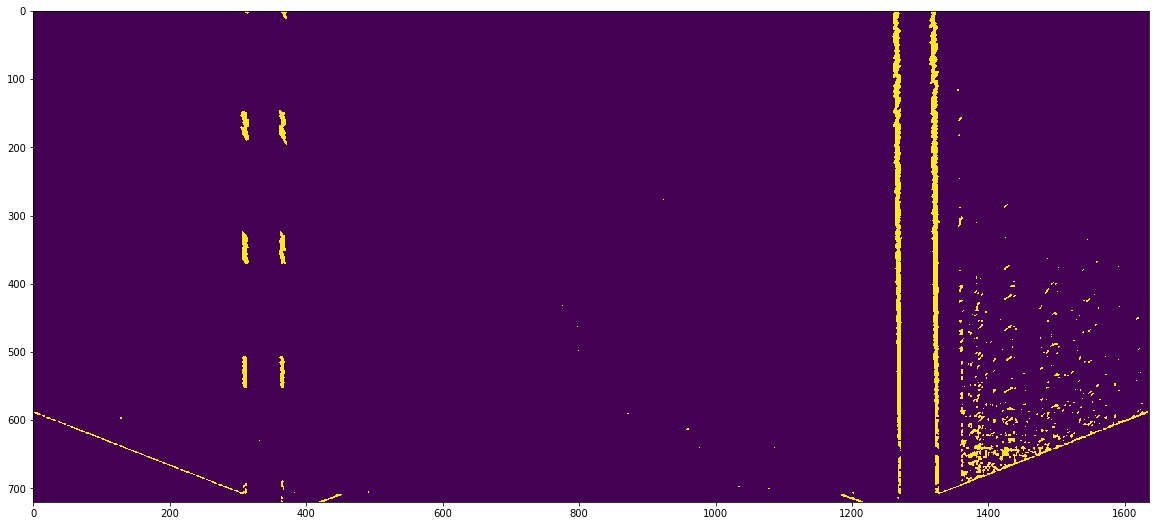

In [11]:
bin_warp = detector.detectStraight(IM)

plt.figure(figsize=(20,10))
plt.imshow(bin_warp)